In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Phase 4 Libraries loaded')

Phase 4 Libraries loaded


## Load Data

In [8]:
file_path = 'd:/S2/prediksi - hujan/merged_all_data_complete.csv'
df = pd.read_csv(file_path)
df['valid_time'] = pd.to_datetime(df['valid_time'])

# Create daily aggregation
daily_data = df.groupby(df['valid_time'].dt.date)[['tp', 'ro', 't2m', 'u10', 'v10', 'swvl1', 'wind_speed']].mean()
daily_data.index = pd.to_datetime(daily_data.index)

print(f'Data loaded and aggregated: {daily_data.shape}')

Data loaded and aggregated: (1827, 7)


## Correlation Matrix (Current Day)

Correlation Matrix:
                tp      ro     t2m     u10     v10   swvl1  wind_speed
tp          1.0000  0.8489 -0.5223  0.1057  0.0871  0.4534      0.0674
ro          0.8489  1.0000 -0.4876  0.0079  0.0310  0.4739     -0.0487
t2m        -0.5223 -0.4876  1.0000  0.1399  0.1716 -0.6430     -0.0275
u10         0.1057  0.0079  0.1399  1.0000  0.5680 -0.0343     -0.0111
v10         0.0871  0.0310  0.1716  0.5680  1.0000 -0.0136      0.4210
swvl1       0.4534  0.4739 -0.6430 -0.0343 -0.0136  1.0000     -0.1624
wind_speed  0.0674 -0.0487 -0.0275 -0.0111  0.4210 -0.1624      1.0000


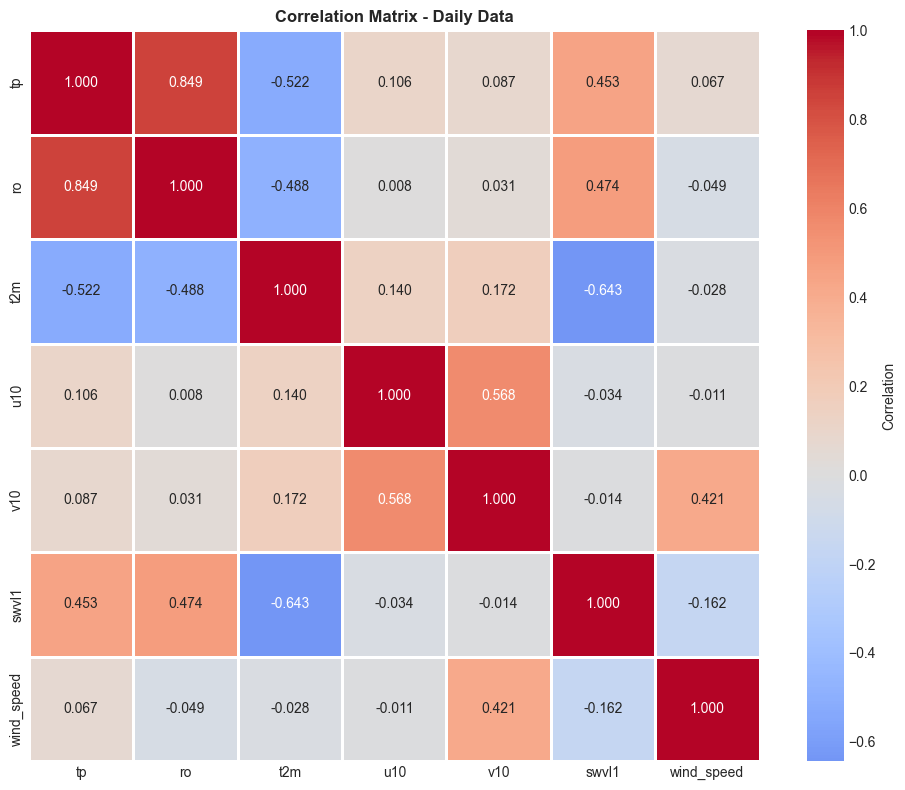


Correlation matrix plot saved


In [9]:
# Correlation matrix
corr_matrix = daily_data.corr()

print('Correlation Matrix:')
print(corr_matrix.round(4))

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'}, ax=ax)
ax.set_title('Correlation Matrix - Daily Data', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('d:/S2/prediksi - hujan/correlation_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

print('\nCorrelation matrix plot saved')

## Lag Analysis: Precipitation → Runoff

Lag Analysis: TP (Precipitation) → RO (Runoff)
Lag  0 days: correlation = 0.8489
Lag  1 days: correlation = 0.8488
Lag  2 days: correlation = 0.8487
Lag  3 days: correlation = 0.8486
Lag  4 days: correlation = 0.8486
Lag  5 days: correlation = 0.8486
Lag  6 days: correlation = 0.8486
Lag  7 days: correlation = 0.8486
Lag  8 days: correlation = 0.8486
Lag  9 days: correlation = 0.8485
Lag 10 days: correlation = 0.8486
Lag 11 days: correlation = 0.8485
Lag 12 days: correlation = 0.8482
Lag 13 days: correlation = 0.8482
Lag 14 days: correlation = 0.8482


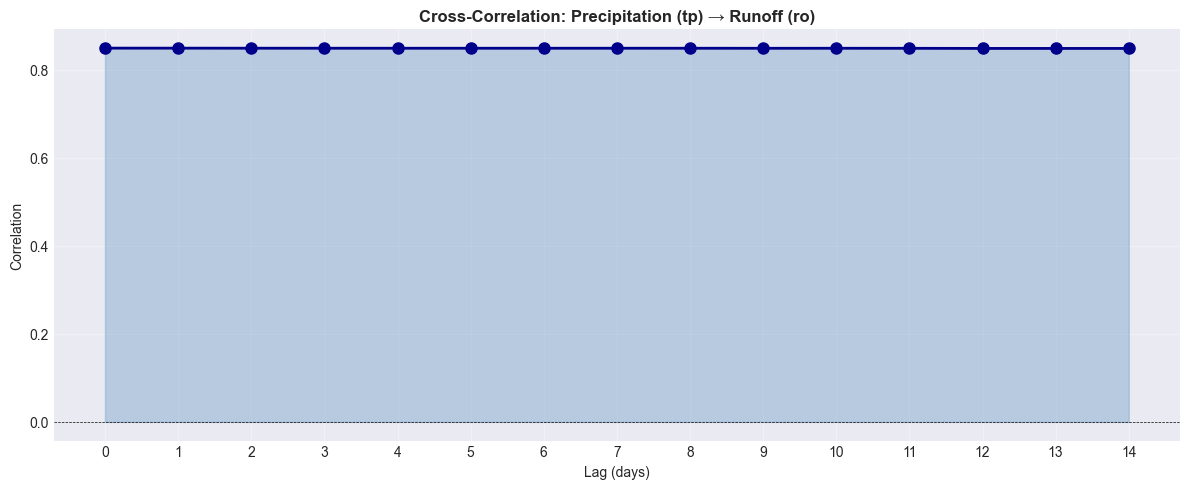


Lag correlation plot saved


In [10]:
# Calculate correlation at different lags
max_lag = 14  # 2 weeks
lag_correlations = []
lag_values = []

for lag in range(0, max_lag + 1):
    if lag == 0:
        corr = daily_data['tp'].corr(daily_data['ro'])
    else:
        corr = daily_data['tp'].iloc[:-lag].corr(daily_data['ro'].iloc[lag:])
    lag_correlations.append(corr)
    lag_values.append(lag)

print('Lag Analysis: TP (Precipitation) → RO (Runoff)')
for lag, corr in zip(lag_values, lag_correlations):
    print(f'Lag {lag:2d} days: correlation = {corr:.4f}')

# Plot
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(lag_values, lag_correlations, 'o-', linewidth=2, markersize=8, color='darkblue')
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax.fill_between(lag_values, lag_correlations, alpha=0.3, color='steelblue')

ax.set_title('Cross-Correlation: Precipitation (tp) → Runoff (ro)', fontsize=12, fontweight='bold')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation')
ax.grid(True, alpha=0.3)
ax.set_xticks(lag_values)

plt.tight_layout()
plt.savefig('d:/S2/prediksi - hujan/lag_correlation_tp_ro.png', dpi=100, bbox_inches='tight')
plt.show()

print('\nLag correlation plot saved')

## Lag Analysis: Multiple Variables

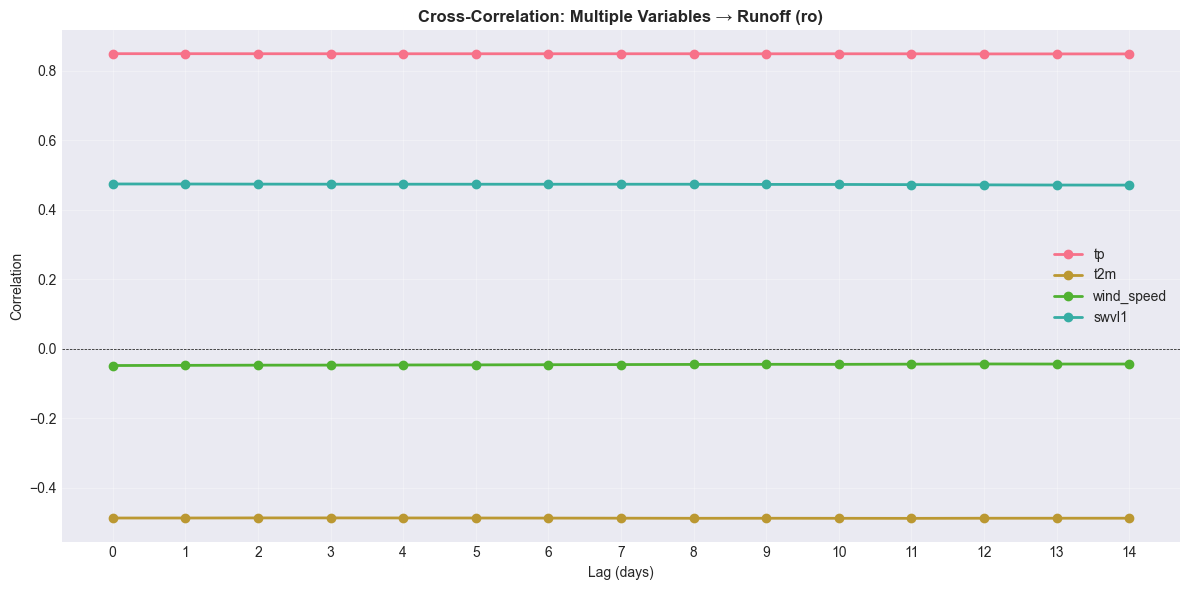

Multi-variable lag correlation plot saved


In [11]:
# Lag correlation for multiple variables with RO (runoff)
max_lag = 14
target = 'ro'
predictors = ['tp', 't2m', 'wind_speed', 'swvl1']

lag_corr_dict = {pred: [] for pred in predictors}

for pred in predictors:
    for lag in range(0, max_lag + 1):
        if lag == 0:
            corr = daily_data[pred].corr(daily_data[target])
        else:
            corr = daily_data[pred].iloc[:-lag].corr(daily_data[target].iloc[lag:])
        lag_corr_dict[pred].append(corr)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

for pred in predictors:
    ax.plot(range(max_lag + 1), lag_corr_dict[pred], 'o-', label=pred, linewidth=2, markersize=6)

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax.set_title('Cross-Correlation: Multiple Variables → Runoff (ro)', fontsize=12, fontweight='bold')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(max_lag + 1))

plt.tight_layout()
plt.savefig('d:/S2/prediksi - hujan/lag_correlation_multivar.png', dpi=100, bbox_inches='tight')
plt.show()

print('Multi-variable lag correlation plot saved')

## Create Lagged Features

In [12]:
# Create lagged features for modeling
# Lags: 1, 2, 3, 6, 7, 14 days

lag_window = [1, 2, 3, 6, 7, 14]
features_with_lags = daily_data.copy()

for col in ['tp', 'ro']:
    for lag in lag_window:
        features_with_lags[f'{col}_lag{lag}'] = daily_data[col].shift(lag)

print('Lagged features created:')
print(f'Original columns: {daily_data.shape[1]}')
print(f'With lags: {features_with_lags.shape[1]}')
print(f'\nColumns: {features_with_lags.columns.tolist()}')
print(f'\nFirst 20 rows (showing tp and lags):')
cols_to_show = ['tp', 'tp_lag1', 'tp_lag2', 'tp_lag3', 'tp_lag6', 'ro', 'ro_lag1']
print(features_with_lags[cols_to_show].head(20))

Lagged features created:
Original columns: 7
With lags: 19

Columns: ['tp', 'ro', 't2m', 'u10', 'v10', 'swvl1', 'wind_speed', 'tp_lag1', 'tp_lag2', 'tp_lag3', 'tp_lag6', 'tp_lag7', 'tp_lag14', 'ro_lag1', 'ro_lag2', 'ro_lag3', 'ro_lag6', 'ro_lag7', 'ro_lag14']

First 20 rows (showing tp and lags):
                  tp   tp_lag1   tp_lag2   tp_lag3   tp_lag6        ro  \
valid_time                                                               
2020-01-01  0.000036       NaN       NaN       NaN       NaN  0.000018   
2020-01-02  0.000018  0.000036       NaN       NaN       NaN  0.000017   
2020-01-03  0.000033  0.000018  0.000036       NaN       NaN  0.000017   
2020-01-04  0.000010  0.000033  0.000018  0.000036       NaN  0.000016   
2020-01-05  0.000016  0.000010  0.000033  0.000018       NaN  0.000017   
2020-01-06  0.000012  0.000016  0.000010  0.000033       NaN  0.000015   
2020-01-07  0.000010  0.000012  0.000016  0.000010  0.000036  0.000015   
2020-01-08  0.000013  0.000010  0.00

## Determine Optimal Lag Window

In [13]:
# Summary of lag analysis findings
print('='*60)
print('OPTIMAL LAG WINDOW DETERMINATION')
print('='*60)

print(f'\nMax correlation TP→RO:')
max_corr_idx = np.argmax(lag_correlations)
print(f'  Lag {lag_values[max_corr_idx]} days: {lag_correlations[max_corr_idx]:.4f}')

print(f'\nKey findings:')
print(f'  - Lag 0 correlation (TP→RO): {lag_correlations[0]:.4f}')
print(f'  - Lag 1 correlation (TP→RO): {lag_correlations[1]:.4f}')
print(f'  - Lag 3 correlation (TP→RO): {lag_correlations[3]:.4f}')
print(f'  - Lag 7 correlation (TP→RO): {lag_correlations[7]:.4f}')

print(f'\nRecommended lag window for model:')
print(f'  - Historical window: 1-7 days (captures precipitation memory)')
print(f'  - Prediction target: RO at lag +1 to +3 days (future runoff)')
print(f'  - Total lookback: 24 hours (hourly resolution needed for accuracy)')

OPTIMAL LAG WINDOW DETERMINATION

Max correlation TP→RO:
  Lag 0 days: 0.8489

Key findings:
  - Lag 0 correlation (TP→RO): 0.8489
  - Lag 1 correlation (TP→RO): 0.8488
  - Lag 3 correlation (TP→RO): 0.8486
  - Lag 7 correlation (TP→RO): 0.8486

Recommended lag window for model:
  - Historical window: 1-7 days (captures precipitation memory)
  - Prediction target: RO at lag +1 to +3 days (future runoff)
  - Total lookback: 24 hours (hourly resolution needed for accuracy)


## Phase 4 Summary

In [14]:
print('='*60)
print('PHASE 4 SUMMARY: CORRELATION & LAG ANALYSIS')
print('='*60)

print(f'\nKey Correlations:')
print(f'  - TP ↔ RO: {corr_matrix.loc["tp", "ro"]:.4f} (same day)')
print(f'  - TP ↔ T2M: {corr_matrix.loc["tp", "t2m"]:.4f} (temperature)')
print(f'  - TP ↔ WIND: {corr_matrix.loc["tp", "wind_speed"]:.4f} (wind)')
print(f'  - RO ↔ SWVL1: {corr_matrix.loc["ro", "swvl1"]:.4f} (soil water)')

print(f'\nLag Effects:')
print(f'  - Precipitation impact on runoff peaks at lag {lag_values[max_corr_idx]} days')
print(f'  - Strong memory effect: high ACF values across 1-14 day lags')
print(f'  - Suitable for LSTM (captures temporal dependencies)')

print(f'\nModeling Implications:')
print(f'  - Use 24h lookback window (hourly data)')
print(f'  - Include features at multiple lag intervals')
print(f'  - Target: predict runoff 1-3 days ahead')

print(f'\nNext: Phase 5 & 6 - Distribution Analysis & Data Quality Report')

PHASE 4 SUMMARY: CORRELATION & LAG ANALYSIS

Key Correlations:
  - TP ↔ RO: 0.8489 (same day)
  - TP ↔ T2M: -0.5223 (temperature)
  - TP ↔ WIND: 0.0674 (wind)
  - RO ↔ SWVL1: 0.4739 (soil water)

Lag Effects:
  - Precipitation impact on runoff peaks at lag 0 days
  - Strong memory effect: high ACF values across 1-14 day lags
  - Suitable for LSTM (captures temporal dependencies)

Modeling Implications:
  - Use 24h lookback window (hourly data)
  - Include features at multiple lag intervals
  - Target: predict runoff 1-3 days ahead

Next: Phase 5 & 6 - Distribution Analysis & Data Quality Report
